In [191]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import astropy.wcs as wcs
import pandas as pd

import butterpy as bp
import trc_funcs as trc

# import eleanor
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
from astropy.stats import sigma_clip


In [2]:
import imp
imp.reload(trc)

<module 'trc_funcs' from '/Users/raeholcomb/Library/CloudStorage/GoogleDrive-rjholcom@uci.edu/My Drive/Research/rotation_collab/trc/trc_funcs.py'>

## Unpacking data 

In [4]:
# unpack the tic overlap lists
# # save the overlap lists
# # ot_overlap =  oelker variable and tara variable
# # nt_overlap =  oelker non and tara non
# # vt_overlap = oelker non and tara variable
# # at_overlap = oelker non and tara non, exclude all gaia variables

with np.load('tic_overlaps.npz', allow_pickle=True) as data:
    ot_overlap = data['ot_overlap']
    nt_overlap = data['nt_overlap']
    vt_overlap = data['vt_overlap']
    at_overlap = data['at_overlap']

In [7]:
# unpack dataframes
# read in LITE version of Tara's more complete variability catalog (has variables and non-variables)
tldf = pd.read_csv('./df_overlap_info.csv')
tldf.rename(columns={'ID':'TIC'}, inplace=True)
print(len(tldf))
tldf[:5]

199422


,TIC,version,GAIA,KIC,objType,ra,dec,Vmag,e_Vmag,Jmag,...,numcont,contratio,RA_orig,Dec_orig,objID,num_s,num_scont,gaia_var,oelk_non,oelk_var
0,1078,20190415,6.222126e+18,0.0,STAR,218.813157,-28.228133,10.738,0.014,8.682,...,0.0,NaN,218.813191,-28.228143,913218723,2,1,0,0,0
1,1307,20190415,6.222241e+18,0.0,STAR,218.813657,-27.858749,10.912,0.010,9.400,...,161.0,0.006025,218.813665,-27.858884,913218893,2,1,0,0,0
2,1454,20190415,6.223004e+18,0.0,STAR,218.755263,-27.601079,10.638,0.007,9.442,...,150.0,0.010204,218.755267,-27.601149,913219000,2,1,0,1,0
3,1608,20190415,6.223044e+18,0.0,STAR,218.785116,-27.346680,9.773,0.007,7.827,...,0.0,NaN,218.785122,-27.346683,913219116,2,1,0,0,0
4,2042,20190415,6.223505e+18,0.0,STAR,218.736983,-26.623713,11.292,0.057,8.710,...,0.0,NaN,218.736953,-26.623717,912203542,2,1,0,0,0


In [6]:
# # read in Tara's variability catalog (VARIABLES ONLY)
tvdf = pd.read_csv('../LScatalog_combined_unique.csv')
print(len(tvdf))
tvdf[:10]

89448


,TIC,Sector,Solution,P [d],Perr [d],A [ppm],Aerr [ppm],T0 [d],T0err [d],offset [ppm],...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,99990178,sp14,1peak,0.619368,0.005539,183.066679,4.465890,0.548541,0.002411,-1.242899,...,0.0,0.765735,0.741300,172.303226,65.550697,0.023637,0.025320,0.0,0.0,143404505
1,99989903,15,1peak,2.521215,0.086137,140.994914,2.890616,2.391561,0.008271,0.036508,...,0.0,1.002679,0.907707,172.258188,63.573608,0.026704,0.026498,1.0,0.0,143404230
2,99989665,15,1peak,3.320700,0.165367,6708.913241,201.080268,0.219024,0.016438,67.104173,...,cooldwarfs_v8,1.753273,1.593195,172.359806,62.125333,0.052553,0.052011,1.0,0.0,143403992
3,99989598,15,1peak,1.374735,0.024906,18.224560,1.131714,0.796916,0.013504,0.024818,...,0.0,1.494076,1.230475,172.267971,61.779393,0.042007,0.040866,1.0,0.0,143403925
4,99989389,sp21,1peak,1.024704,0.017791,134.774350,7.934109,0.558792,0.009576,-1.651280,...,0.0,0.804408,0.687529,172.214219,60.452305,0.021282,0.021739,1.0,0.0,143403716
5,99982385,sp14,1peak,0.978354,0.016493,619.232869,10.165877,0.215492,0.002624,28.997151,...,0.0,0.963359,0.998497,310.432461,32.774020,0.027643,0.034239,-1.0,0.0,416294944
6,99972480,sp21,1peak,0.389549,0.002118,80.297915,4.708262,0.000303,0.003629,-0.098011,...,0.0,0.930109,0.846342,171.805795,62.111259,0.024921,0.027930,1.0,0.0,143322179
7,99971936,15,1peak,1.442471,0.039834,158.860846,4.472598,0.362390,0.006403,0.178251,...,0.0,1.174940,1.117111,171.642440,61.391342,0.031231,0.035881,0.0,0.0,143321670
8,99971790,14,1peak,7.000660,0.700169,358.783229,18.617873,5.677312,0.055707,-30.742909,...,0.0,0.787537,0.841547,171.631112,62.230561,0.023100,0.028686,1.0,0.0,143321551
9,99971569,sp15,1peak,0.387242,0.002454,1017.901271,6.222511,0.203131,0.000379,-6.059535,...,0.0,0.876464,0.781997,171.540347,63.826804,0.025053,0.027319,1.0,0.0,143321359


In [8]:
# For now, grab a smaller data frame called the cdf
# which is what we will use while working with Christina
# # at_overlap = oelker non and tara non, exclude all gaia variables
cdf = tldf[tldf.TIC.isin(at_overlap)]
print(len(cdf))

41044


In [32]:
cdf[:5]

,TIC,version,GAIA,KIC,objType,ra,dec,Vmag,e_Vmag,Jmag,...,numcont,contratio,RA_orig,Dec_orig,objID,num_s,num_scont,gaia_var,oelk_non,oelk_var
2,1454,20190415,6.223004e+18,0.0,STAR,218.755263,-27.601079,10.638,0.007,9.442,...,150.0,0.010204,218.755267,-27.601149,913219000,2,1,0,1,0
6,3709,20190415,6.272082e+18,0.0,STAR,218.876538,-24.344873,9.272,0.004,7.565,...,0.0,NaN,218.876350,-24.345075,913220745,2,1,0,1,0
11,12678,20190415,6.223034e+18,0.0,STAR,219.227761,-27.390209,9.966,0.005,8.944,...,137.0,0.052256,219.227796,-27.390252,914251986,2,1,0,1,0
12,12767,20190415,6.222276e+18,0.0,STAR,219.200724,-27.520580,9.948,0.004,8.793,...,161.0,0.014443,219.200593,-27.520691,914252075,2,1,0,1,0
13,16598,20190415,6.223545e+18,0.0,STAR,219.307897,-26.202102,11.296,0.034,9.548,...,0.0,NaN,219.307938,-26.202493,915302613,2,1,0,1,0


## Generate butterpy signals

In [29]:
np.random.seed(77)

period = 5.0    # in days

star = bp.regions(
    butterfly=True, 
    activity_rate=3,   # times solar rate
    cycle_length=5, 
    cycle_overlap=.5,   # 0 is pole on
    decay_time=(period*15),
    max_ave_lat=45, 
    min_ave_lat=20,
    alpha_med=(3*3e-4)
)

spots = bp.Spots(
    star, 
    alpha_med=(3*3e-4), 
    period=period,
    incl=1, 
    decay_timescale=10, 
    diffrot_shear=0.25
)

In [30]:
# set up mock lightcurve
time = np.arange(40, 200, .5)
flux = 1 + spots.calc(time)

lc = pd.DataFrame(np.c_[time, flux], columns=['time', 'flux'])


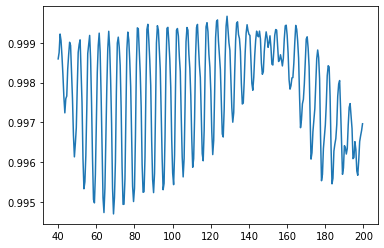

In [31]:
# modified

plt.plot(time,flux)
plt.show()

## Scratch

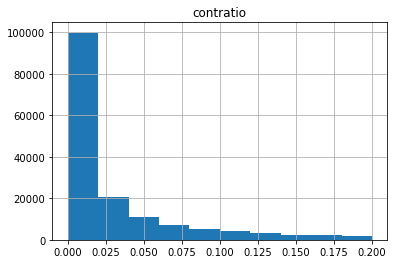

In [33]:
# Try to figure out if contratio is useful or not
tldf.hist(column="contratio")
plt.show()

In [34]:
tldf.sort_values(by=['contratio'], ascending=False, inplace=False)

,TIC,version,GAIA,KIC,objType,ra,dec,Vmag,e_Vmag,Jmag,...,numcont,contratio,RA_orig,Dec_orig,objID,num_s,num_scont,gaia_var,oelk_non,oelk_var
136042,302625238,20190415,5.217480e+17,0.0,STAR,28.347648,70.042622,8.890,0.030,8.292,...,398.0,0.199942,28.347889,70.042642,26216355,6,2,2,0,0
187665,438613498,20190415,6.088420e+18,0.0,STAR,201.685053,-43.864090,10.169,0.007,8.454,...,344.0,0.199929,201.685456,-43.864160,850486584,3,1,0,0,0
9813,21108045,20190415,6.077519e+18,0.0,STAR,186.850389,-51.923067,15.942,0.011,11.879,...,718.0,0.199919,186.848839,-51.922909,800619672,4,2,0,0,0
96727,225040372,20190415,5.972951e+18,0.0,STAR,257.870724,-39.314583,10.943,0.012,9.058,...,3164.0,0.199919,257.870686,-39.314925,1192179577,3,1,0,0,0
68262,157295117,20190415,4.523226e+18,0.0,STAR,274.650153,17.714064,11.676,0.048,10.112,...,572.0,0.199916,274.650081,17.713652,191433637,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199416,2044088451,20190415,1.990987e+18,0.0,STAR,347.738178,50.050920,NaN,NaN,NaN,...,0.0,NaN,347.738216,50.050921,494433464,3,2,2,0,0
199418,10002431953,20190415,0.000000e+00,0.0,EXTENDED,184.610352,29.812820,NaN,NaN,11.101,...,0.0,NaN,NaN,NaN,1727181931,1,1,2,0,0
199419,10005000001,20190415,0.000000e+00,0.0,EXTENDED,10.684710,41.268749,NaN,NaN,2.094,...,0.0,NaN,NaN,NaN,1727248513,2,1,0,0,0
199420,10005000078,20190415,0.000000e+00,0.0,EXTENDED,187.705933,12.391100,NaN,NaN,6.719,...,0.0,NaN,NaN,NaN,1727248565,2,1,0,0,0


In [44]:
# grab "crowded" example from lightkurve tutorial, check contratio
lc = lk.search_lightcurve("KIC 2437317", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")
print(lc.meta['CROWDSAP'])

0.9765


In [80]:
# grab "crowded" example from lightkurve tutorial, check contratio
lc = lk.search_lightcurve("KIC 2437901", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")
print(lc.meta['CROWDSAP'])

0.9915


In [50]:
# Check CROWDSAP for Tara's "contaminated" targets
# tic 302625238
lc = lk.search_lightcurve("TIC 302625238", author='SPOC').download(quality_bitmask="hard")
print(lc.meta['CROWDSAP'])



/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


0.82462317


In [90]:
# pick 10 random TICS from the sorted tldf
# rand_inds should be good to use!
# rand_inds1 = np.rint((np.logspace(0, 1, num=10)-1) * len(tldf)/10).astype(int)
rand_inds = np.rint((np.logspace(0, 2, num=10)-1)/10 * len(tldf)/10).astype(int)
rand_inds2 = np.rint((np.logspace(0, 2, num=20)-1)/10 * len(tldf)/10).astype(int)
print(rand_inds)
print(rand_inds1)
# plt.plot(rand_inds)
# plt.plot(rand_inds1)
plt.show()

[     0   1332   3555   7262  13446  23762  40970  69674 117556 197428]
[     0   5814  13323  23022  35548  51726  72621  99608 134463 179480]


In [91]:
tldf.sort_values(by=['contratio'], ascending=False, inplace=False).iloc[rand_inds2]

,TIC,version,GAIA,KIC,objType,ra,dec,Vmag,e_Vmag,Jmag,...,numcont,contratio,RA_orig,Dec_orig,objID,num_s,num_scont,gaia_var,oelk_non,oelk_var
136042,302625238,20190415,5.217480e+17,0.0,STAR,28.347648,70.042622,8.890,0.030,8.292,...,398.0,0.199942,28.347889,70.042642,26216355,6,2,2,0,0
10649,22242383,20190415,6.148012e+18,0.0,STAR,183.621638,-42.970765,12.735,0.069,10.004,...,243.0,0.193607,183.621277,-42.970876,791253798,3,1,0,0,0
22517,47245744,20190415,5.756094e+18,0.0,STAR,134.671194,-7.993618,10.671,0.007,9.469,...,88.0,0.185688,134.670940,-7.994428,660847491,3,1,0,1,0
57977,141714191,20190415,5.266125e+18,0.0,STAR,91.235010,-72.853347,12.814,0.126,10.944,...,757.0,0.176166,91.235296,-72.853010,557472463,35,13,0,0,0
87968,199666111,20190415,1.432072e+18,0.0,STAR,251.904145,59.909007,10.038,0.005,8.884,...,54.0,0.165679,251.904034,59.909049,163511964,28,13,0,0,0
29092,63009781,20190415,2.126164e+18,8165738.0,STAR,291.788067,44.080028,11.423,0.013,10.381,...,469.0,0.153066,291.788140,44.080006,286078884,5,2,0,1,0
48227,117403375,20190415,4.398527e+17,0.0,STAR,48.387986,51.301287,12.816,0.103,11.146,...,333.0,0.139182,48.389004,51.300567,43973572,2,1,0,1,0
32057,68901227,20190415,1.355676e+18,0.0,STAR,249.690583,39.389028,11.767,0.023,10.453,...,49.0,0.123784,249.690603,39.388751,162198380,4,2,0,0,0
118047,265870350,20190415,3.456445e+18,0.0,STAR,86.982458,37.709269,13.101,0.041,10.352,...,399.0,0.107671,86.982751,37.708891,89823473,2,1,0,1,0
189903,441946248,20190415,5.307887e+18,0.0,STAR,145.753048,-55.594584,9.968,0.004,8.882,...,1794.0,0.091283,145.753141,-55.594881,687400564,5,2,0,0,0


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


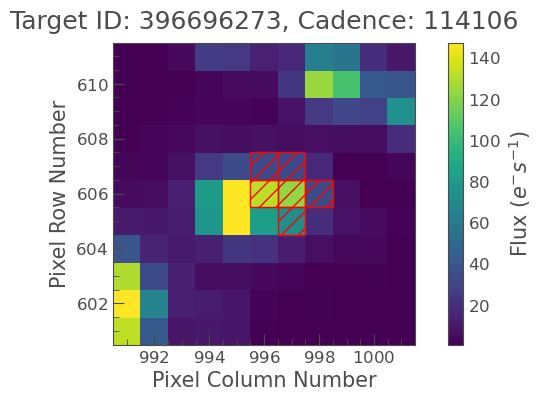

In [94]:
tpf_crowded = lk.search_targetpixelfile("TIC 396696273", author='SPOC').download(quality_bitmask="hard")
# print(tpf_crowded.meta['CROWDSAP'])

# lk.search_targetpixelfile("KIC 2437901", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")
tpf_crowded.plot(aperture_mask='pipeline');

In [ ]:
# list of approved fields
# Crowded (hopefully?)
# TIC 252606684 - 2 continuous sectors
# TIC 141714191 - 13 sec
# TIC 199666111 - 13 sec


# Medium
# 

# Uncrowded


# Developing Goddard Pipeline 

In [350]:
imp.reload(trc)

<module 'trc_funcs' from '/Users/raeholcomb/Library/CloudStorage/GoogleDrive-rjholcom@uci.edu/My Drive/Research/rotation_collab/trc/trc_funcs.py'>

In [211]:
# pick a star/field to work with
tic = 396696273
# tic = 199666111
name = "TIC " + str(tic)
ra,dec = tldf.loc[tldf.TIC==tic]['ra'].values[0], tldf.loc[tldf.TIC==tic]['dec'].values[0]


In [ ]:
# grab the real TESS cut out
cutout_size=20
tpf_cutout = trc.get_cutout(name, cutout_size=cutout_size)
tpf_cutout.plot();

# grab the catalog of sources
source_cat = trc.get_catalog(name, cutout_size=cutout_size)


In [335]:
imp.reload(trc)

<module 'trc_funcs' from '/Users/raeholcomb/Library/CloudStorage/GoogleDrive-rjholcom@uci.edu/My Drive/Research/rotation_collab/trc/trc_funcs.py'>

In [189]:
tpf.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'TELESCOP': 'Kepler',
 'INSTRUME': 'Kepler Photometer',
 'OBJECT': 'KIC 2437317',
 'KEPLERID': 2437317,
 'RADESYS': 'ICRS',
 'RA_OBJ': 290.21807,
 'DEC_OBJ': 37.76407,
 'EQUINOX': 2000.0,
 'EXPOSURE': 86.02658604,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2454833,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 93.44267104,
 'LIVETIME': 86.02658604,
 'TSTART': 906.83633815,
 'TSTOP': 1000.2790092,
 'LC_START': 55739.34343282,
 'LC_END': 55832.76587042,
 'DEADC': 0.92063492,
 'TIMEPIXR': 0.5,
 'TIERRELA': 5.78e-07,
 'TIERABSO': <astropy.io.fits.card.Undefined at 0x7fc11d21e520>,
 'INT_TIME': 6.01980290327,
 'READTIME': 0.518948526144,
 'FRAMETIM': 6.538751429414,
 'NUM_FRM': 270,
 'TIMEDEL': 0.02043359821692,
 'DATE-OBS': '2011-06-27T07:59:49.865Z',
 'DATE-END': '2011-09-28T18:37:33.934Z',
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAIN': 111.23,
 'READNOIS': 87.604748,
 'NREADO

In [346]:
# flux to mag conversions - NOT WORKING
def flux_to_mag_old(flux, reference_flux=1.74e5):
    """NOTE: ref mag is a place holder from kepler right now!"""
    kepmag = 12 - 2.5 * np.log10(flux/reference_flux)
    return kepmag

def mag_to_flux_old(mag, reference_flux=1.74e5):
    """NOTE: ref mag is a place holder from kepler right now!"""
    fkep = (10.0**(-0.4*(mag - 12.0)))*reference_flux
    # f12 = 1.74e5 # electrons/sec
    return fkep

def mag_to_flux(mag, reference_flux=2486.30):
    """NOTE: ref mag is a place holder from kepler right now!"""
    fkep = (10.0**(-0.4*(mag)))*reference_flux
    # f12 = 1.74e5 # electrons/sec
    return fkep

# this equation gives flux in ergs/s, need in e-/s
lambda_ref = 7697.58
def func(flux):
    return 1/(2.9979246) * 1e5 * (lambda_ref**2) * flux

mag = source_cat[0]['Tmag']
print(mag)
mag_to_flux_old(mag, reference_flux=2486.30)


13.8321


459.9530785022862

121.848206
(1077, 20, 20)


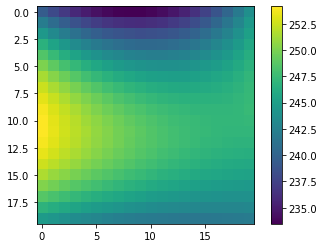

In [355]:
# work on modeling the background
# first step is to use the source catalog to mask sources
print(np.median(tpf_cutout[0].flux.value))
np.median(tpf_cutout.flux.value, axis=[1,2])

# bkg = trc.estimate_bkg(tpf_cutout, source_cat)
bkg = trc.fit_bkg(tpf_cutout, polyorder=2)
print(np.shape(bkg))
plt.imshow(bkg[0])
plt.colorbar()


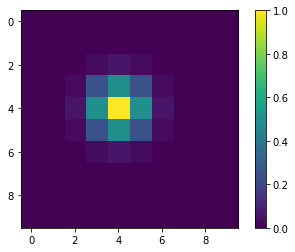

4.532371887240516 7.3890560989306495


In [397]:
# work on gaussian smearing the sources
imp.reload(trc)

def makeGaussian(size_x, size_y, fwhm = 1.3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum (units of pixels), which
    can be thought of as an effective radius.

    Note: NOT normalized correctly! But that shouldn't matter.
    """
    x = np.arange(0, size_x, 1, float)[np.newaxis, :]
    y = np.arange(0, size_y, 1, float)[:, np.newaxis]

    if center is None:
        x0 = size_x // 2
        y0 = size_y // 2
    else:
        x0 = center[0]
        y0 = center[1]

    # make and normalize so that the who image sums to 1
    arr = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return arr


out = trc.makeGaussian(10, 10, fwhm=2, center=[4,4])
plt.imshow(out)
plt.colorbar()
plt.show()
print(np.sum(out), np.e**2)

In [ ]:
lightkurve/src/lightkurve/prf
SimpleKeplerPRF

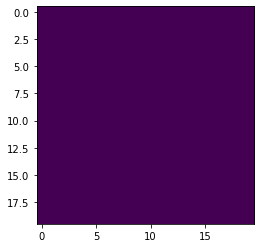

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

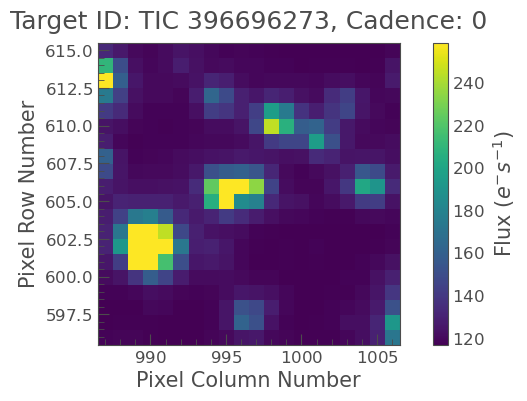

In [401]:
imp.reload(trc)
def generate_gaussian_field(tpf_cutout, source_cat, plot=False, buffer=3):
    """Given a source catalog and tpf_cutout, generates a field with gaussian sources. Currently is very jank and just proof of concept. The list of sources in read in and then the single pixel nearest their location is given a value weighed by 16-Tmag. The plot keyword will plot the tpf_cutout and the basic field, rotated so that they hopefully line up. 

    Inputs (incomplete):
        buffer - the code will ignore any targets provided that fall more than this number of pixels outside of the tpf

    Known issues: 
    - Values are not real fluxes 
    - the pixel numbers on the axes don't line up with the real tpf pixel numbers 
    - jank rounding for ra/dec --> pixel conversion
    """
    # set up field
    field = np.ones_like(tpf_cutout.flux.value)

    # convert source coords to integer pixel numbers
    pix1, pix2 = np.rint(tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)).astype(int)

    # cut out indices where the target falls significantly outside the cutout
    shape = np.shape(field)
    cut = (pix1 < shape[1]+buffer) & (pix1 >= 0-buffer) & (pix2 < shape[2]+buffer) & (pix2 >= 0-buffer)
    source_cut = source_cat[cut]

    # add sources to the field, weighted by Tmag
    fwhm_arr = 16 - source_cat['Tmag'][cut]
    for source_ind in range(len(source_cut)):
        gauss = trc.makeGaussian(shape[1], shape[2], fwhm=fwhm_arr[source_ind], center=[pix1[source_ind],pix2[source_ind]])
        field = np.multiply(field, gauss)
        # field[:,pix1[cut],pix2[cut]] = 16 - source_cat['Tmag'][cut]

    # plot if requested
    if plot:
        plt.imshow(np.rot90(field[0]))
        plt.show()
        tpf_cutout.plot();
    
    return field

gauss_field = generate_gaussian_field(tpf_cutout, source_cat, plot=True, buffer=3)

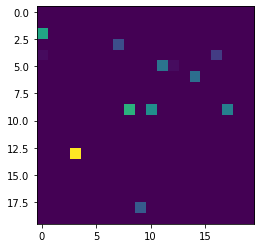

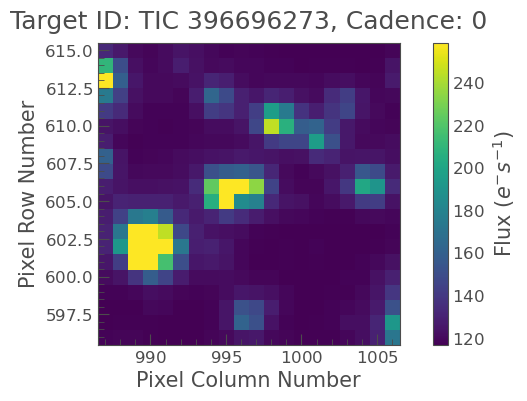

In [326]:
imp.reload(trc)
field = trc.generate_basic_field(tpf_cutout, source_cat, plot=True)


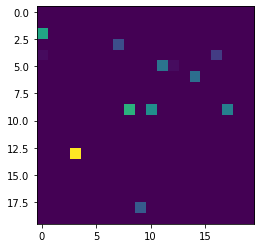

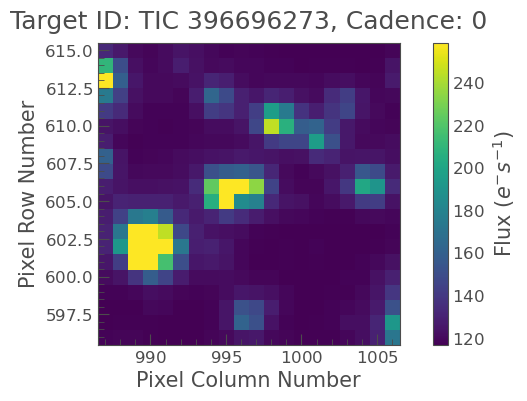

In [320]:
# set up the fake star field
# imp.reload(trc)
field = np.zeros_like(tpf_cutout.flux.value)
# print(np.shape(tpf_cutout))
# print(np.shape(field))

# ra1, dec1 = source_cat[0]['ra'], source_cat[0]['dec']
pix1, pix2 = np.rint(tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)).astype(int)

# cut out indices where the target falls outside the cutout
shape = np.shape(field)
cut = (pix1 < shape[1]) & (pix1 >= 0) & (pix2 < shape[2]) & (pix2 >= 0)

# change the pixels where the sources fall to 1
# np.shape(field)
# print(pix1)
# print(pix2)
# print(len(pix1, len(pix2)))
field[:,pix1[cut],pix2[cut]] = 16 - source_cat['Tmag'][cut]

plt.imshow(np.rot90(field[0]))
plt.show()
tpf_cutout.plot();


In [327]:
tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)


[array([ 9.70511727,  7.7981655 , 11.03109983, 11.35948497, 12.3170203 ,
        14.13558002,  7.21036813, 17.48693711, 15.76887041,  2.69348503,
         9.34087545,  0.3642109 , -0.96172894, -0.32423597, 20.17730921,
        11.42148789, -3.92073258, 23.4416721 , 20.77676878, 12.01715741]),
 array([10.13428224,  9.54006985, 14.34524306, 14.32941418, 14.09736932,
        13.19673262, 15.75029646, 10.04488305, 15.43915221,  5.95346347,
         1.41768788, 15.17050864, 11.67830826, 17.31719713, 17.16910284,
        -3.15026896,  7.54283231,  6.86975334,  0.40723979, -4.4445014 ])]

In [194]:
# grab the positional catalog
from astroquery.mast import Catalogs
import astropy.units as u
import astropy.wcs as wcs


catalog_data = Catalogs.query_object(name, catalog="TIC", radius=trc.pixels_to_radius(cutout_size))

# catalog_data = Catalogs.query_object(name, catalog="TIC", width=trc.pix_to_arcsec(cutout_size)*u.arcsecond)

print(len(catalog_data))
print(len(catalog_data[catalog_data['Tmag'] < 16]))

# print(catalog_data[:10])


129
20


In [143]:
imp.reload(trc)
# px = 20
# # trc.roundup(px / np.sqrt(2) * 21 / 3600, pow=-2)
# trc.pixels_to_radius(20)

<module 'trc_funcs' from '/Users/raeholcomb/Library/CloudStorage/GoogleDrive-rjholcom@uci.edu/My Drive/Research/rotation_collab/trc/trc_funcs.py'>

In [202]:
import astropy.io.fits as fits
import os
filename = os.path.join(wcs.__path__[0], 'tests/data/j94f05bgq_flt.fits')
hdulist = fits.open(filename)
# hdulist[('sci',1)].header
# w = wcs.WCS(hdulist[('sci',1)].header, hdulist)
# hdulist.close()



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 5.63056810618  -72.05457184278998  
CRPIX : 2048.0  1024.0  
CD1_1 CD1_2  : 1.29056256197165e-05  5.95309123310338e-06  
CD2_1 CD2_2  : 5.0220581265601e-06  -1.2644774105568e-05  
NAXIS : 1  1

In [218]:
w = tpf_cutout.wcs
radec = w.all_pix2world([1,2,3], [1,1,1], 1)
ra1, dec1 = w.all_pix2world([1,2,3], [1,1,1], 1)
print(radec)
print(ra1, dec1)

recover_pix = w.all_world2pix(radec[0], radec[1], 1)
recover_pix1 = w.all_world2pix(ra1, dec1, 1)
print(recover_pix)
print(recover_pix1)


[array([65.33176083, 65.33716003, 65.34255794]), array([-55.22266473, -55.2178913 , -55.21311764])]
[65.33176083 65.33716003 65.34255794] [-55.22266473 -55.2178913  -55.21311764]
[array([1., 2., 3.]), array([1., 1., 1.])]
[array([1., 2., 3.]), array([1., 1., 1.])]


In [ ]:
# start making fake starfield


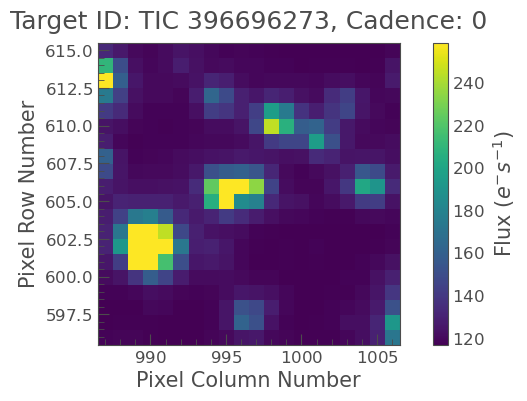

In [103]:
# building up get_coutout
search_result = lk.search_tesscut(name)
search_result

tpf_cutout = search_result[0].download(cutout_size=20)
tpf_cutout.plot();